In [1]:
from math import pi
import numpy as np
from scipy import signal 
import matplotlib.pyplot as plt
import wavio
import IPython
import random

In [2]:
def P2R(A, phi):
    return A * ( np.cos(phi) + np.sin(phi) * 1j )

In [3]:
def PreProcessData(xn, frameSize, stepSize):
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    iteration = int(len(temp) // stepSize) - int(frameSize // stepSize) + 1
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = temp[start:end]
        
    return dataSet, temp, len(temp), iteration

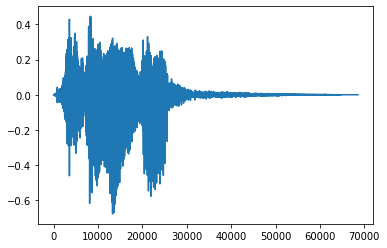

In [4]:
file = wavio.read("china.wav")
fixed_data0 = file.data[:, 0]
fixed_data1 = file.data[:, 1]
data = fixed_data0.astype(np.float32, order='C') / 32767.0

plt.plot(data)
plt.show()

IPython.display.display(IPython.display.Audio("china.wav", rate=file.rate))

In [5]:
fs = file.rate
frameSize = 1024
stepSize = 128
dataSet, data, length, iteration = PreProcessData(data, frameSize, stepSize)

In [6]:
output = np.zeros(length)
for i in range(iteration):
    temp = dataSet[i] * signal.hann(frameSize)
    X = np.fft.fft(temp)
    spectra = np.abs(X)
    phase = np.zeros(frameSize)
    X_synthesis = P2R(spectra, phase)
    yn = np.fft.ifft(X_synthesis).real * signal.hann(frameSize)
    
    start = i * stepSize
    end = start + frameSize
    
    output[start:end] = output[start:end] + yn

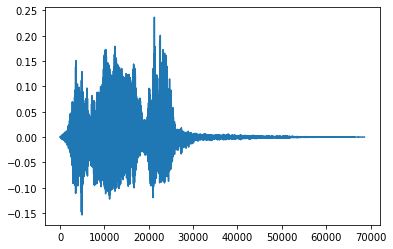

In [7]:
plt.plot(output)
plt.show()
wavio.write("output.wav", output, fs, sampwidth=3)
IPython.display.display(IPython.display.Audio("output.wav", rate=fs))

In [ ]:
s, fs = librosa.load("../wavs/Reich_Music18.wav")

# audio fragment
t1 = 10*fs
t2 = 18*fs
sigin = s[t1:t2]

#output input size
L = sigin.size

#size of analysis window and soverlap
N = 2048
H = int(N/4)

#output audio size
Lout = sigin.size

# signal blocks for processing and output
phi  = zeros(N)
out = zeros(N, dtype=complex)
sigout = zeros(L)

# max input amp, window
win = hanning(N)
p = 0

while p < L-(N+H):

    # take the spectra of two consecutive windows     
    spec1 =  fft(win*sigin[p:p+N])
    spec2 =  fft(win*sigin[p+H:p+N+H])
    # take their phase difference and integrate
    phi += (angle(spec2) - angle(spec1))
    
    # bring the phase back to between pi and -pi    
    phi =  (( -phi + pi) % (2.0 * pi ) - pi) * -1.0       
    
    out.real, out.imag = cos(phi), sin(phi)
    
    # inverse FFT and overlap-add        
    sigout[p:p+N] += win*ifft(out*abs(spec2)).real
    
    p += H